# BRD4 Interpolation in Latent Space

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import rdkit.Chem.PandasTools as PandasTools

PandasTools.InstallPandasTools()

In [4]:
import os

### Analysis Variables

In [5]:
blob="lig_gen"

### Helper Functions

TODO: Extract such functions in a Python module.

In [6]:
def root_and_prefix(datafile):
    """
    Root directory and prefix.
    """
    dataroot = os.path.dirname(datafile)
    prefix, _ = os.path.splitext(os.path.basename(datafile))
    
    return dataroot, prefix

## Variability Factor 1.0

### Data

In [7]:
droot = "data/BRD4/sdf/"

In [8]:
datafile = "generated/BRD4interpolation_vf1.0_inter.gen_metrics"

Load generative model metrics (from `*.gen_metrics` file):

In [9]:
dataroot, prefix = root_and_prefix(datafile)
prefix

'BRD4interpolation_vf1.0_inter'

In [10]:
system = prefix.split("_")[0]
system

'BRD4interpolation'

In [11]:
with open(f"data/{system}.types", "r") as f:
    inputs = f.readlines()
    
inputs

['1 0.00 BRD4/pdb/BRD4.pdb BRD4/sdf/ligand-1_min.sdf\n',
 '1 0.00 BRD4/pdb/BRD4.pdb BRD4/sdf/ligand-10_min.sdf\n',
 '1 0.00 BRD4/pdb/BRD4.pdb BRD4/sdf/ligand-2_min.sdf\n',
 '1 0.00 BRD4/pdb/BRD4.pdb BRD4/sdf/ligand-3_min.sdf\n']

In [12]:
def ligname(line):
    ligfile = line.strip().split()[-1]
    ligname = os.path.splitext(os.path.basename(ligfile))[0]
    return ligname

ligand_pairs = [(ligname(inputs[i]), ligname(inputs[i+1])) for i in range(0, len(inputs), 2)]
ligand_pairs

[('ligand-1_min', 'ligand-10_min'), ('ligand-2_min', 'ligand-3_min')]

In [13]:
interpolations = {}

In [14]:
for ligandpair in ligand_pairs:
    molecules = []
    
    lig1, lig2 = ligandpair
    
    # Start molecule
    molecules.append(next(Chem.SDMolSupplier(f"{droot}/{lig1}.sdf")))
    AllChem.Compute2DCoords(molecules[0])
    
    lig1f = f"generated/{prefix}_{lig1}_{blob}_fit_add.sdf"
    suppl1 = Chem.SDMolSupplier(lig1f)
    for mol in suppl1:
        if mol is not None:
            AllChem.Compute2DCoords(mol)
            molecules.append(mol)
            
    lig2f = f"generated/{prefix}_{lig2}_{blob}_fit_add.sdf"
    suppl2 = Chem.SDMolSupplier(lig2f)
    for mol in suppl2:
        if mol is not None:
            AllChem.Compute2DCoords(mol)
            molecules.append(mol)
            
    # End molecule
    molecules.append(next(Chem.SDMolSupplier(f"{droot}/{lig2}.sdf")))
    AllChem.Compute2DCoords(molecules[-1])
            
    interpolations[f"{lig1}/{lig2}"] = molecules

In [15]:
def tsimilarity(molecules):
    
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024) for mol in molecules]
    
    start_fp = fps[0]
    end_fp = fps[-1]
    
    sim_with_start = []
    sim_with_end = []
    for fp in fps:
        sim_with_start.append(DataStructs.FingerprintSimilarity(fp,start_fp))
        sim_with_end.append(DataStructs.FingerprintSimilarity(fp,end_fp))
        
    return sim_with_start[1:-1], sim_with_end[1:-1]

In [16]:
def msimilarity(molecules):
    from rdkit.Chem import MACCSkeys
    
    fps = [MACCSkeys.GenMACCSKeys(mol) for mol in molecules]
    
    start_fp = fps[0]
    end_fp = fps[-1]
    
    sim_with_start = []
    sim_with_end = []
    for fp in fps:
        sim_with_start.append(DataStructs.FingerprintSimilarity(fp,start_fp))
        sim_with_end.append(DataStructs.FingerprintSimilarity(fp,end_fp))
        
    return sim_with_start[1:-1], sim_with_end[1:-1]

## First Interpolation

In [17]:
idx = 0 # Interpolation index (first pair, second pair, ...)
key = list(interpolations.keys())[idx]

In [18]:
key

'ligand-1_min/ligand-10_min'

In [19]:
tsim_start, tsim_end = tsimilarity(interpolations[key])

Text(0, 0.5, 'Tanimoto Similatiry')

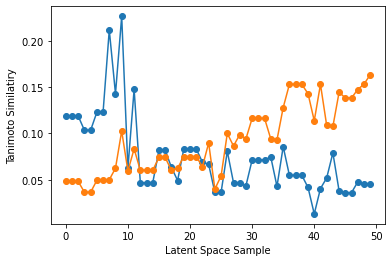

In [20]:
plt.plot(range(len(tsim_start)), tsim_start,"o-", label="Similatiry to START")
plt.plot(range(len(tsim_end)), tsim_end,"o-", label="Similarity to END")
plt.xlabel("Latent Space Sample")
plt.ylabel("Tanimoto Similatiry")

In [21]:
msim_start, msim_end = msimilarity(interpolations[key])

Text(0.5, 1.0, 'MACCS')

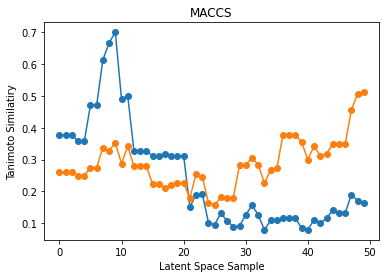

In [22]:
plt.plot(range(len(tsim_start)), msim_start,"o-", label="Similatiry to START")
plt.plot(range(len(tsim_end)), msim_end,"o-", label="Similarity to END")
plt.xlabel("Latent Space Sample")
plt.ylabel("Tanimoto Similatiry")
plt.title("MACCS")

In [23]:
df = pd.DataFrame().from_dict({"sim_start": tsim_start, "sim_end": tsim_end})
df.head()

,sim_start,sim_end
0,0.118644,0.048193
1,0.118644,0.048193
2,0.118644,0.048193
3,0.103448,0.036585
4,0.103448,0.036585


In [24]:
df.index = interpolations[key][1:-1]
df.columns = [interpolations[key][0], interpolations[key][-1]]

,,
,0.118644,0.048193
,0.118644,0.048193
,0.118644,0.048193
,0.103448,0.036585
,0.103448,0.036585
,0.122807,0.049383
,0.122807,0.049383
,0.211538,0.050000
,0.142857,0.062500
,0.226415,0.102564

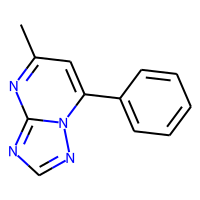
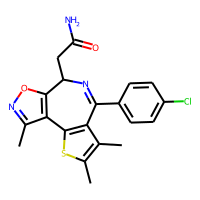
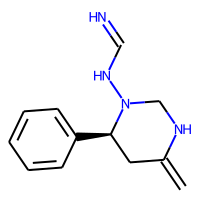
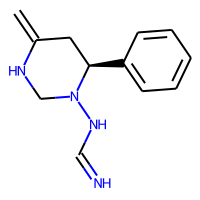
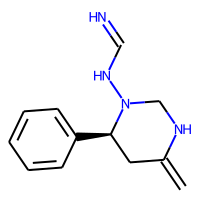
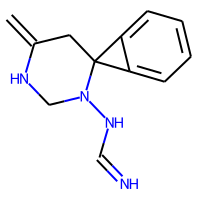
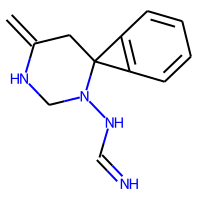
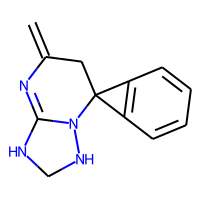
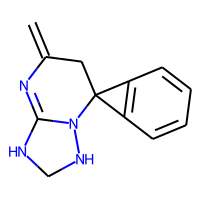
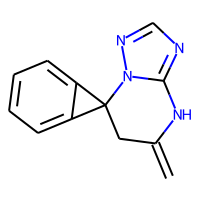
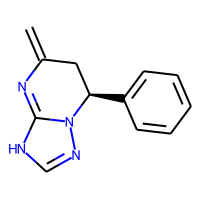
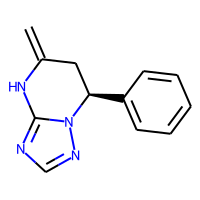
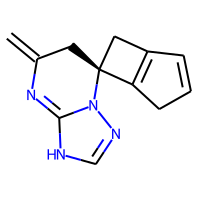
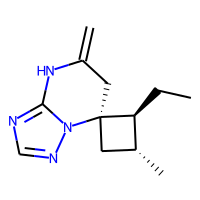
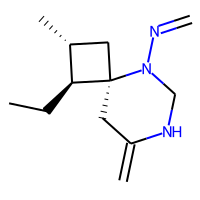
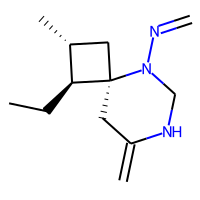
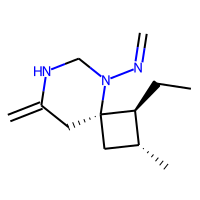
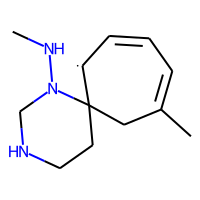
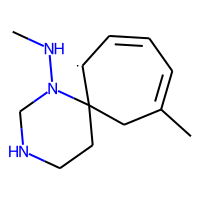
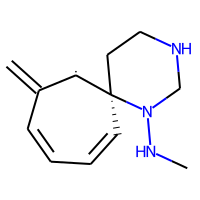
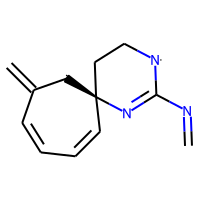
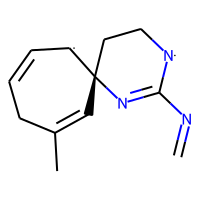
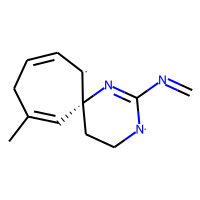
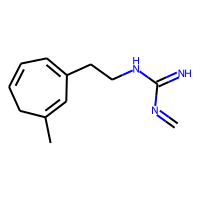
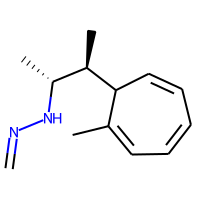
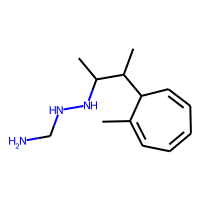
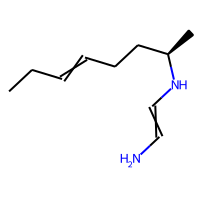
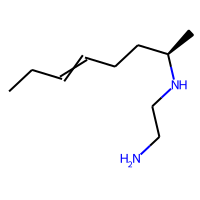
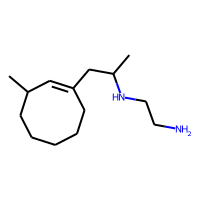
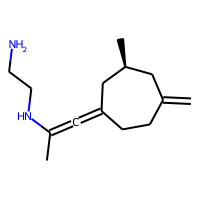
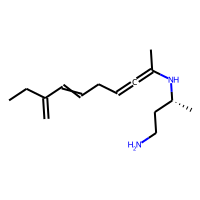
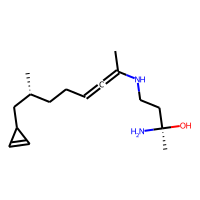
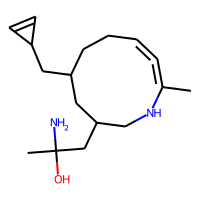
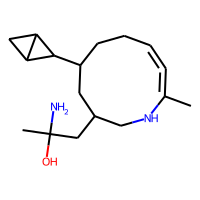
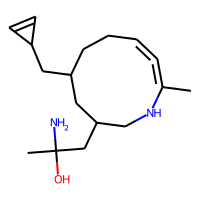
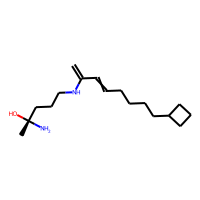
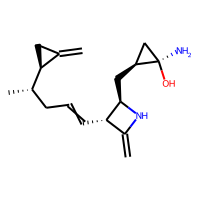
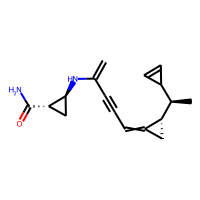
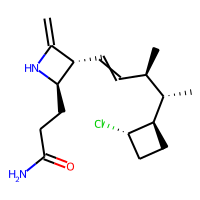
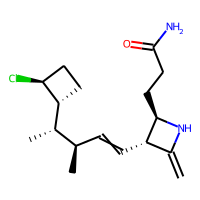
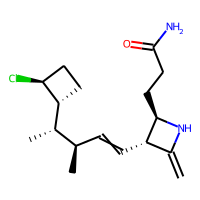
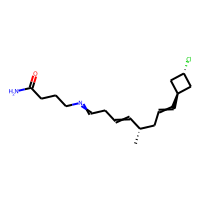
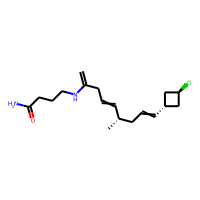
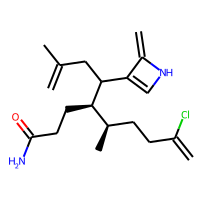
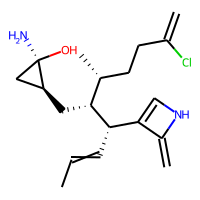
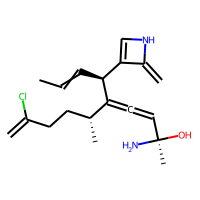
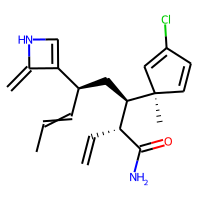
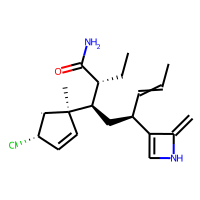
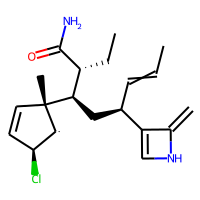
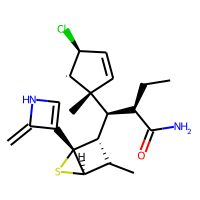
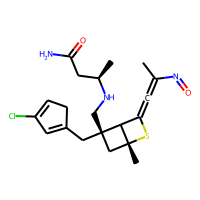
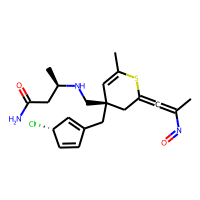

In [25]:
df.style.background_gradient(cmap=sns.cm.rocket, vmin=0, vmax=1)

<AxesSubplot:>

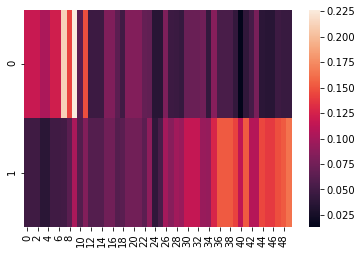

In [26]:
sns.heatmap(df.to_numpy().T)

## Second Interpolation

In [27]:
idx = 1 # Interpolation index (first pair, second pair, ...)
key = list(interpolations.keys())[idx]

In [28]:
key

'ligand-2_min/ligand-3_min'

In [29]:
tsim_start, tsim_end = tsimilarity(interpolations[key])

Text(0, 0.5, 'Tanimoto Similatiry')

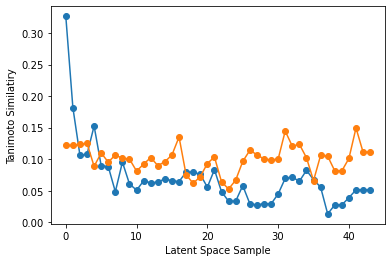

In [30]:
plt.plot(range(len(tsim_start)), tsim_start,"o-", label="Similatiry to START")
plt.plot(range(len(tsim_end)), tsim_end,"o-", label="Similarity to END")
plt.xlabel("Latent Space Sample")
plt.ylabel("Tanimoto Similatiry")

In [31]:
msim_start, msim_end = msimilarity(interpolations[key])

Text(0.5, 1.0, 'MACCS')

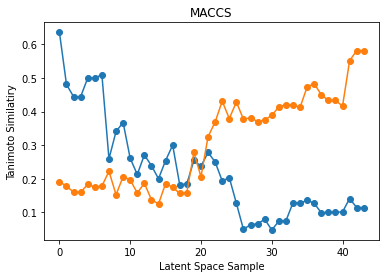

In [32]:
plt.plot(range(len(tsim_start)), msim_start,"o-", label="Similatiry to START")
plt.plot(range(len(tsim_end)), msim_end,"o-", label="Similarity to END")
plt.xlabel("Latent Space Sample")
plt.ylabel("Tanimoto Similatiry")
plt.title("MACCS")

In [33]:
df = pd.DataFrame().from_dict({"sim_start": tsim_start, "sim_end": tsim_end})
df.head()

,sim_start,sim_end
0,0.326531,0.121622
1,0.181818,0.121622
2,0.106061,0.123457
3,0.107692,0.125000
4,0.152542,0.088608


In [34]:
df.index = interpolations[key][1:-1]
df.columns = [interpolations[key][0], interpolations[key][-1]]

,,
,0.326531,0.121622
,0.181818,0.121622
,0.106061,0.123457
,0.107692,0.125000
,0.152542,0.088608
,0.089552,0.109756
,0.088235,0.095238
,0.048387,0.106667
,0.095238,0.101266
,0.060606,0.100000

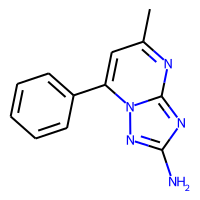
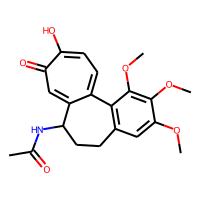
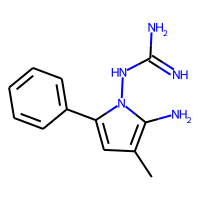
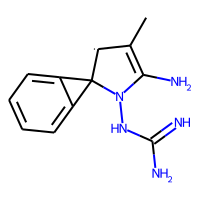
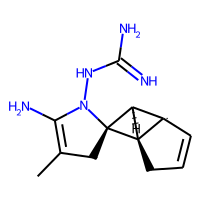
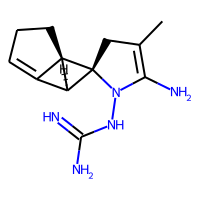
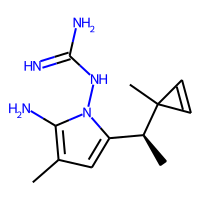
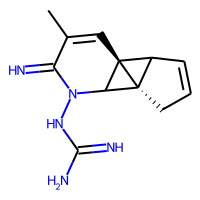
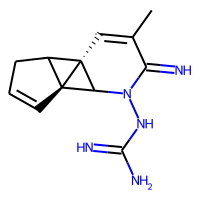
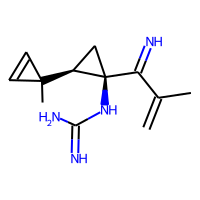
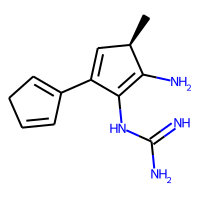
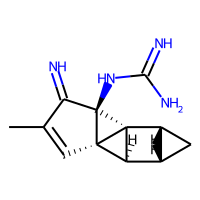
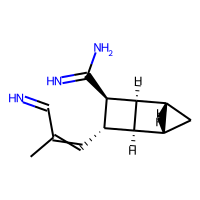
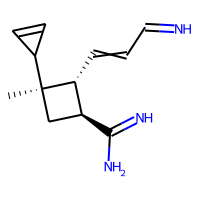
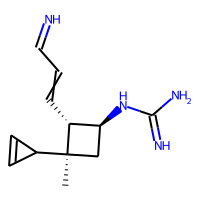
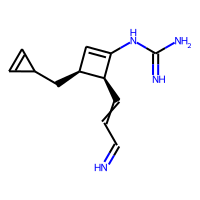
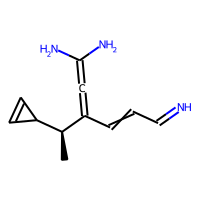
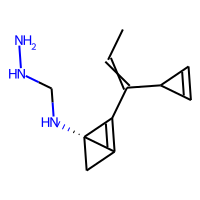
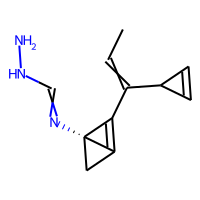
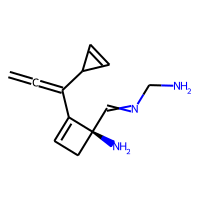
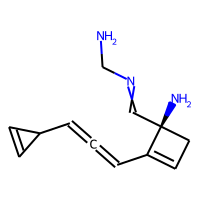
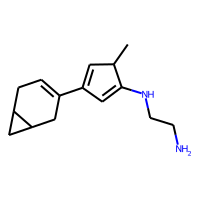
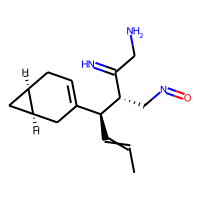
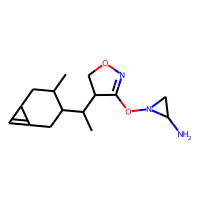
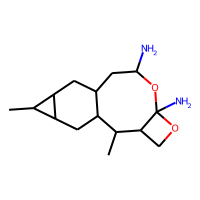
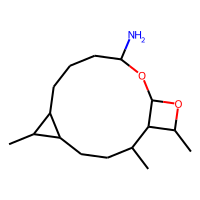
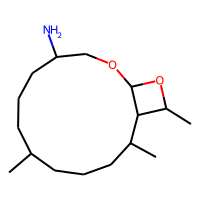
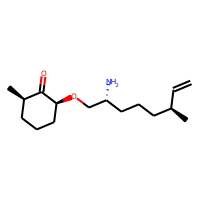
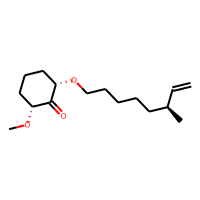
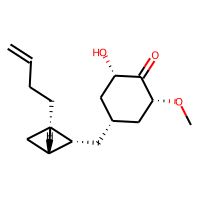
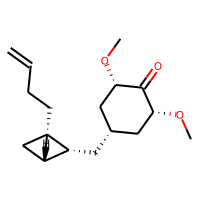
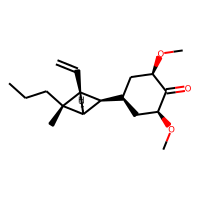
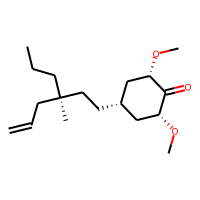
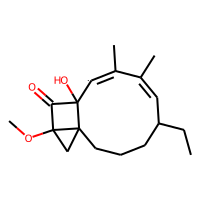
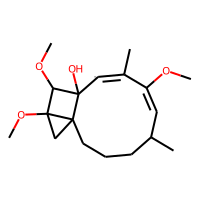
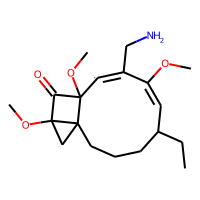
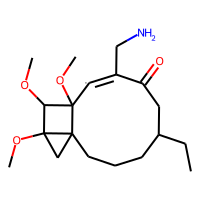
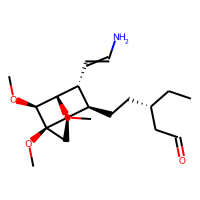
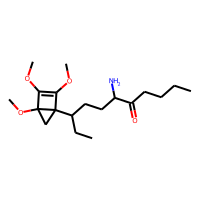
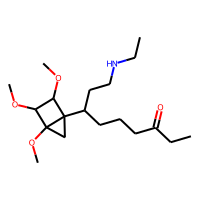
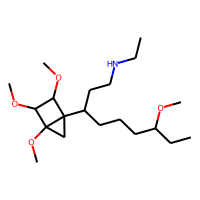
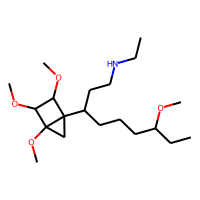
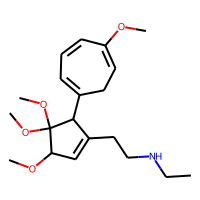
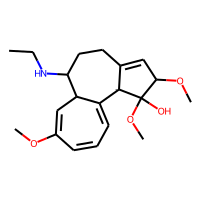
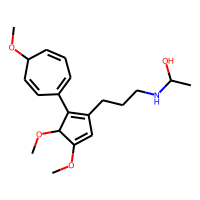
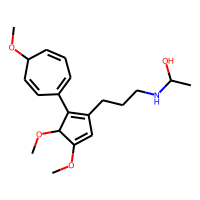

In [35]:
df.style.background_gradient(cmap=sns.cm.rocket, vmin=0, vmax=1)

<AxesSubplot:>

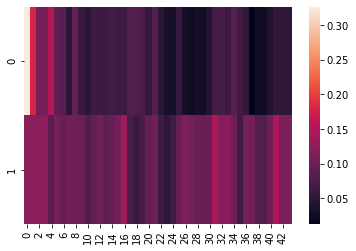

In [36]:
sns.heatmap(df.to_numpy().T)